# Demonstration: Dislocation Differential Displacement Plot

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Chandler A. Becker**, [chandler.becker@nist.gov](mailto:chandler.becker@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Zachary T. Trautt**, [zachary.trautt@nist.gov](mailto:zachary.trautt@nist.gov?Subject=ipr-demo), *Materials Measurement Science Division, NIST*.

Version: 2015-08-28

[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm)

- - -

## Software

This notebook was tested with:

- LAMMPS (Version 2015-03-27)

- Python (Version 2.7.6)

- IPython (Version 2.0.0)

- - -

## Introduction

This Notebook creates a differential displacement plot for a dislocation monopole system. 

Related calculations:

- tool-Dislocation-Creation: creates an atomic system containing a dislocation monopole.

- tool-Dislocation-Nye-Tensor: calculates the Nye Tensor for all atoms in a system.


- - -

##1. Initial Setup

1. __Necessary Python Libraries__: This is a list of the Python libraries used to run this code. 

2. __Necessary Parameters__: These are the parameters that need to be specified to run the code.

3. __Calculation Parameters__: These are user-specified parameters that control how the calculation proceeds, such as number of data points.

###1.1 Necessary Python Libraries

This is a list of the Python libraries used to run this code. 

- Numpy can be found [here](http://www.numpy.org/).

- Matplotlib can be found [here](http://matplotlib.org/).

- iprp is contained in the IPR code download.

In [1]:
#Standard Python Libraries
import os
from copy import deepcopy
import sys

#Additional Python Libraries
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.collections import PatchCollection

#Custom package
import atomman as am

###1.2 Necessary Parameters

These are the parameters that need to be specified to run the code.

__Note:__ The default example shown here assumes that you have previously run the default example for the tool-Dislocation-Creation Notebook.  The directory and file information supplied here refers to what was created using that tool.

- working_dir is the working directory where you want this Notebook to run. 

- base_file is the name (and location) of the LAMMPS dump file associated with the dump_file but does not contain a dislocation.

- dump_file is the name (and location) of the LAMMPS dump file that you want to create the differential displacement plot for.

- base_elements is a list of the elements to be associated with the atom types in the base_file.  

- dump_elements is a list of the elements to be associated with the atom types in the dump_file.  Note that with systems created by the tool-Dislocation-Creation Notebook, the atom types are doubled.  For example, if you have a three element system, then elements = [El1, El2, El3, El1, El2, El3].

- a0 is the lattice parameter a for the system. This is used here to properly scale dimensions used in the plotting. 

- disl_file is the name (and location) of the dislocation monopole library data model file.  This is used here as each crystal prototype requires specific inputs related to performing the Nye tensor calculation.

- disl_type is the specific tag associated with a particular dislocation type listed in the disl_file. 

In [2]:
#Specify working directory
working_dir = 'tool-Dislocation'
os.chdir(working_dir)
working_dir = os.getcwd()

#Specify LAMMPS dump files to calculate DD plot
base_file = 'fcc--Al--(a-2)[(1)(0)(-1)]--((1)(1)(1))--u[(1)(0)(-1)]--base.dump'
dump_file = 'fcc--Al--(a-2)[(1)(0)(-1)]--((1)(1)(1))--u[(1)(0)(-1)]--disl.dump'

#base_file = 'fcc--Al--(a-2)[(1)(0)(-1)]--((1)(1)(1))--u[(1)(-2)(1)]--base.dump'
#dump_file = 'fcc--Al--(a-2)[(1)(0)(-1)]--((1)(1)(1))--u[(1)(-2)(1)]--disl.dump'

#Give the cubic lattice parameter, a0
a = 4.0500

#Specify point defect library data model file
disl_file = 'fcc-disl.json'

#Specify which dislocation type was used
disl_type = '(a-2)[(1)(0)(-1)]--((1)(1)(1))--u[(1)(0)(-1)]'
#disl_type = '(a-2)[(1)(0)(-1)]--((1)(1)(1))--u[(1)(-2)(1)]'

###1.3 Calculation Parameters

These are user-specified parameters that control how the calculation proceeds, such as number of data points.

- xy_plot_range defines the xy window of the system to use in creating the plot.

- ddscale is a multiplying factor that is performed on the magnitude of the differential displacement vectors.  

__Note:__ for bcc screw dislocations, the typical ddscale factor used in papers is 1.8856.  Adding a second number in the brackets will create the edge component map for this type of dislocation, however there is some discrepancy in the positive-negative sense of the edge component vectors with published plots.  

In [3]:
#Define the xy plot range window
xy_plot_range = [[-15, 15], [-15, 15]]

#Scale the differential displacement vectors
ddscale = [1]

##2. Additional Data Files

To make this notebook self-contained, we have embedded a few files.

None for this calculation.

__Note:__ The default example shown here assumes that you have previously run the default example for the tool-Dislocation-Creation Notebook.  The necessary files are created using that tool.

##3. LAMMPS Script Generation Function(s)

This code generates the underlying LAMMPS script(s) for performing the necessary simulations.  

None for this calculation

##4. Python Calculation Function(s)

These functions are associated with setting up the atomic systems, running LAMMPS, extracting the simulation data, and refining the results.

- ax_check() checks that a crystallographic axes set is orthogonal and returns both the associated normalization vectors and the magnitudes associated with those directions.  Note that the normalized vector array is the transformation matrix, T, relative to a [100],[010],[001] orientation.

- mag() returns the magnitude of a vector of any dimension.

- dd() computes and plots the differential displacement map. base is a dislocation-free system corresponding to the dislocation-containing system. A neighbor list needs to be built for the base system.  data is the dislocation-containing system. prange defines the xyz box dimensions for including atoms in the plot. burgers is the Burgers vector for the system (in the system's Cartesian coordinates). scale is a scaling factor. save sets whether the figure is saved to a file 'dd.png'. show sets whether the figure is displayed.

In [4]:
#Checks that the axes are orthogonal and returns normalized direction vectors
#The normalized array is the transformation matrix, T, relative to a [1,0,0],[0,1,0],[0,0,1] orientation
def axes_check(axes, tol=1e-8):
    mag = np.apply_along_axis(np.linalg.norm, 1, axes)
    uaxes = axes / mag[:,None]
    if (np.isclose(np.dot(uaxes[0], uaxes[1]), 0., atol=tol) == False or 
        np.isclose(np.dot(uaxes[0], uaxes[2]), 0., atol=tol) == False or 
        np.isclose(np.dot(uaxes[1], uaxes[2]), 0., atol=tol) == False):
        raise ValueError('dots are not 0!')
    if np.allclose(np.cross(uaxes[0], uaxes[1]) - uaxes[2], np.zeros(3), atol=tol) == False:
        raise ValueError('cross does not check!')
    return uaxes, mag

def mag(vect):
    #return np.linalg.norm(vect)  Runs slower...
    m = 0
    for v in vect:
        m += v**2
    return (m)**.5  

def dd(base, data, prange, burgers, scale=[1], save=False, show=True):
    #initialize fig and define image size
    if len(scale)==1:
        fig, ax1, = plt.subplots(1, 1, squeeze=True, figsize=(7,7), dpi=72)
    elif len(scale)==2:
        fig, (ax1, ax2) = plt.subplots(1, 2, squeeze=True, figsize=(16,7), dpi=72)
    wscale = 1./200.
    bmag = mag(burgers)
    radius = bmag/10
    bvect = burgers/bmag
    
    natoms = base.natoms()
    nlist = base.prop('nlist')
    
    for i in xrange(natoms):
        #identify all base atoms i in prange
        pos = base.atoms(i, 'pos')
        if (pos[2] > prange[2,0] and pos[2] < prange[2,1] and
            pos[1] > prange[1,0] and pos[1] < prange[1,1] and
            pos[0] > prange[0,0] and pos[0] < prange[0,1]):
            
            #Construct xy map of base atom positions colored by z position
            color = cm.hsv((pos[2] - prange[2,0]) / (prange[2,1] - prange[2,0]) )
            ax1.add_patch(mpatches.Circle((pos[0], pos[1]), radius, fc=color))
            if len(scale)==2:
                ax2.add_patch(mpatches.Circle((pos[0], pos[1]), radius, fc=color))
            
            #for all neighbors j of base atoms i
            for jj in xrange(nlist[i][0]):
                j = nlist[i][jj+1] 
                
                deltabase = base.dvect(i, j)
                #if the base atoms have different xy coordinates
                if mag(deltabase[:2]>1e-5):
                    deltadata = data.dvect(i, j)
                    
                    #c = centerpoint, dd = differential displacement vector for i-j
                    c = (base.atoms(i, 'pos') + base.atoms(j, 'pos')) / 2
                    dd = (deltadata - deltabase)
                    ddcomp = dd.dot(bvect)
                    if ddcomp > bmag / 2:
                        ddcomp -= bmag
                    elif ddcomp < -bmag / 2:
                        ddcomp += bmag
                    
                    dds = deltabase[:2] / mag(deltabase[:2]) * ddcomp * scale[0]
                    wide = mag(dds) * wscale
                    ax1.quiver(c[0], c[1], dds[0], dds[1], angles='xy', scale_units='xy', scale=1, pivot='middle', width=wide)
                    ax1.axis([prange[0,0], prange[0,1], prange[1,0], prange[1,1]])
                    
                    if len(scale)==2:
                        dde = dd[:2] * scale[1]
                        if deltabase[2] > 0:
                            dde = -dde

                        wide = mag(dde) * wscale
                        ax2.quiver(c[0], c[1], dde[0], dde[1], angles='xy', scale_units='xy', scale=1, pivot='middle', width=wide)
                        ax2.axis([prange[0,0], prange[0,1], prange[1,0], prange[1,1]])
    
    if save:
        plt.savefig('DD.png', dpi=800)
    if show==False:
        plt.close(fig)
    plt.show()        


##5. Run Calculation and Display Results

This is the code that runs the calculation function(s) for the supplied inputs and displays the resulting data.

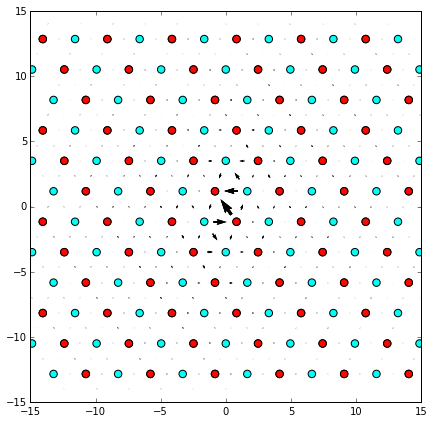

In [5]:
#Read the data model files
dislocations = am.tools.DislocationMonopole(disl_file)

#Define run parameters
burgers = a * dislocations.get(disl_type, 'burgers')
axes = dislocations.get(disl_type, 'axes')
T,vmag = axes_check(axes)
b = T.dot(burgers)

#Read in the dislocation-free base system
sys0 = am.lammps.read_dump(base_file) 

#Calculate nearest neighbor list
sys0.neighbors(a * dislocations.get('Nye_cutoff'))

#Read in the dislocation containing system
sys2 = am.lammps.read_dump(dump_file)

#Calculate the DD plot 
plot_range = np.array([xy_plot_range[0], xy_plot_range[1], a * dislocations.get(disl_type, 'zwidth') ])
dd(sys0, sys2, plot_range, b, scale=ddscale, save=True)

#Change plot file names to avoid conflicts
dot_index = dump_file.index('.')
fname = dump_file[:dot_index] + '--ddplot.png'

try:
    os.rename('dd.png', fname)
except:
    os.remove(fname)
    os.rename('dd.png', fname)